In [1]:
# ==== 定义函数（一次性运行即可） ====
import os, re, pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = [
    'SimHei', 'Microsoft YaHei', 'HanaMinA', 'Source Han Sans CN',
    'Noto Sans CJK SC', 'WenQuanYi Zen Hei', 'PingFang SC', 'sans-serif'
]
plt.rcParams['axes.unicode_minus'] = False

def _find_sheet_like(xls: pd.ExcelFile, target_exact: str, fallback_contains: str) -> str:
    sheets = [s.strip() for s in xls.sheet_names]
    if target_exact in sheets:
        return target_exact
    norm_map = {re.sub(r"\s+", "", s): s for s in sheets}
    key = re.sub(r"\s+", "", target_exact)
    if key in norm_map:
        return norm_map[key]
    for s in sheets:
        if fallback_contains in s:
            return s
    return sheets[0]

def _get_offset_series(df: pd.DataFrame) -> pd.Series:
    col = None
    for c in df.columns:
        if str(c).strip().lower() == "offset":
            col = c
            break
    if col is None:
        if df.shape[1] >= 2:
            col = df.columns[1]
        else:
            raise ValueError("表中缺少 'Offset' 列，且列数不足以回退到第2列。")
    return pd.to_numeric(df[col], errors="coerce").dropna().astype(float)

def _maybe_sort_by_bufid(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if str(c).strip().lower() == "bufid":
            return df.sort_values(by=c, kind="mergesort")
    return df

def plot_for_file(xlsx_path: str, out_dir: str):
    """为单个Excel生成两张图：箱线图 + 热力图；返回保存路径列表。"""
    os.makedirs(out_dir, exist_ok=True)
    xls = pd.ExcelFile(xlsx_path)
    task_name = os.path.splitext(os.path.basename(xlsx_path))[0]
    m = re.match(r"(.+?)_memory_analysis", task_name)
    task_name = m.group(1) if m else task_name

    # 1) 箱线图：完整有效数据
    sheet_valid = _find_sheet_like(xls, "完整有效数据", "完整")
    df_valid = pd.read_excel(xlsx_path, sheet_name=sheet_valid)
    offsets_valid = _get_offset_series(df_valid)

    plt.figure(figsize=(5, 4), dpi=160)
    plt.boxplot(offsets_valid.values, vert=True, widths=0.4, showfliers=True)
    plt.title(f"{task_name} — Offset分布箱线图", fontsize=10)
    plt.ylabel("Offset", fontsize=9)
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    out_box = os.path.join(out_dir, f"{task_name}_offset_boxplot.png")
    plt.savefig(out_box, bbox_inches="tight")
    plt.close()

    # 2) 热力图：小 BufId 数据
    sheet_small = _find_sheet_like(xls, "小 BufId 数据", "小")
    df_small = pd.read_excel(xlsx_path, sheet_name=sheet_small)
    df_small = _maybe_sort_by_bufid(df_small)
    offsets_small = _get_offset_series(df_small)
    arr = offsets_small.values.reshape(-1, 1)

    plt.figure(figsize=(6, max(2, min(10, len(offsets_small) * 0.03))), dpi=160)
    im = plt.imshow(arr, aspect="auto", cmap="RdBu_r", interpolation="nearest")
    plt.title(f"{task_name} — 小BufId的Offset热力图", fontsize=10)
    plt.xlabel("Offset色阶", fontsize=9)
    n = len(offsets_small)
    if n > 1:
        step = max(1, n // 20)
        plt.yticks(list(range(0, n, step)), fontsize=7)
    plt.xticks([])
    cbar = plt.colorbar(im, fraction=0.035, pad=0.04)
    cbar.set_label("Offset", fontsize=9)
    plt.tight_layout()
    out_heat = os.path.join(out_dir, f"{task_name}_offset_heatmap.png")
    plt.savefig(out_heat, bbox_inches="tight")
    plt.close()

    return [out_box, out_heat]


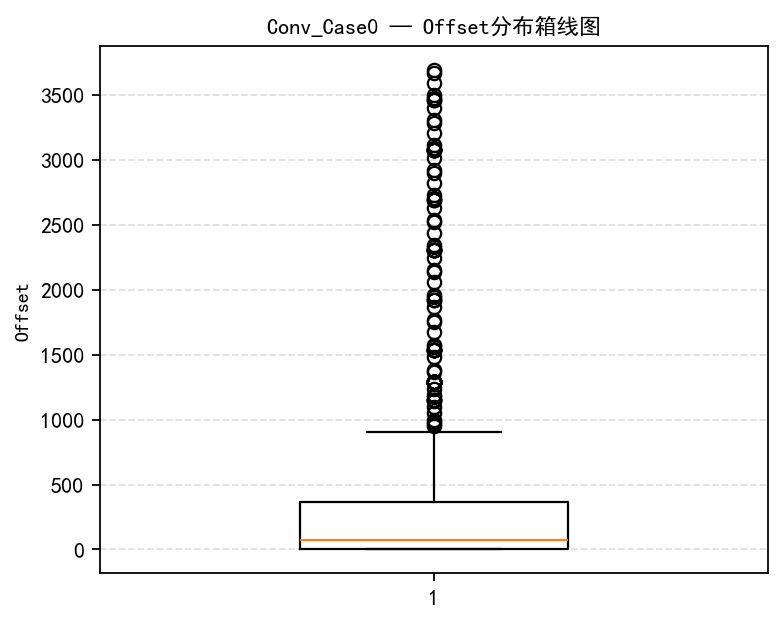

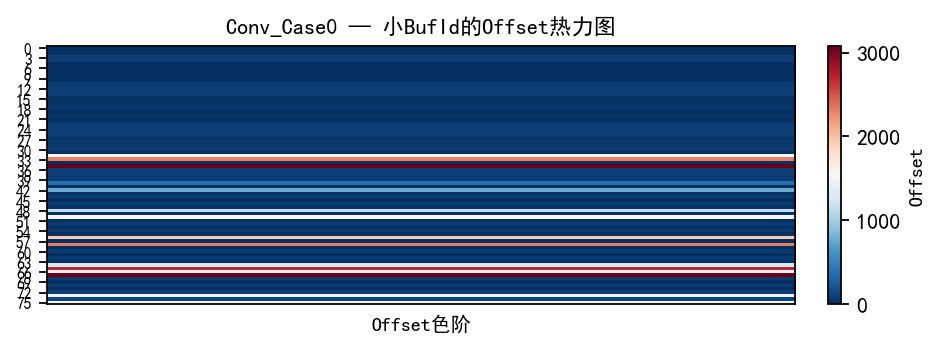

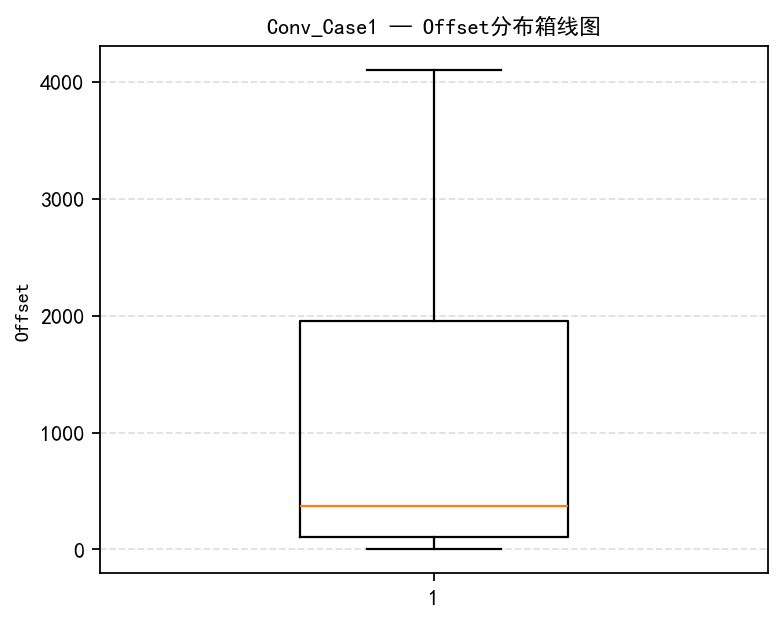

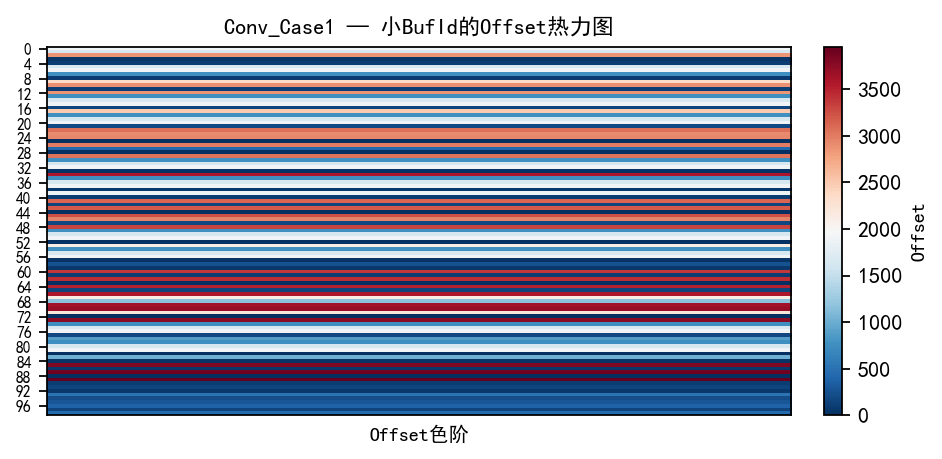

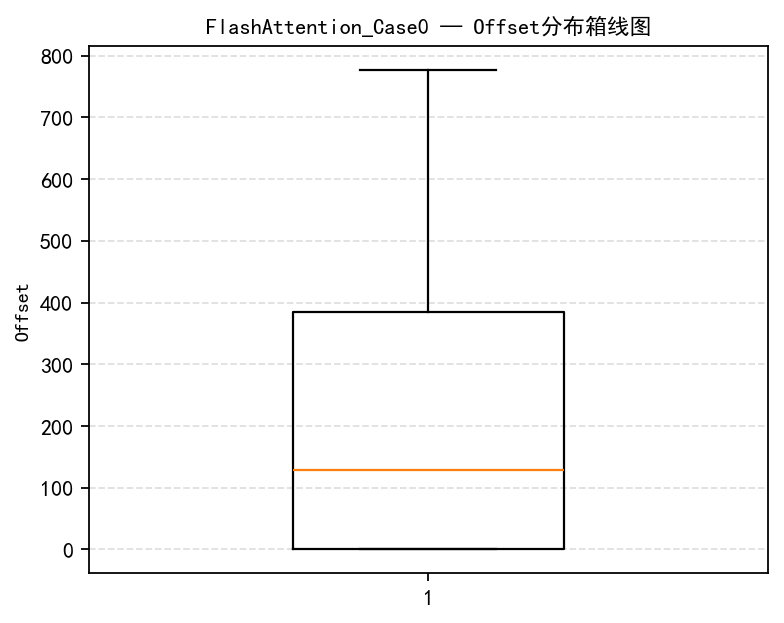

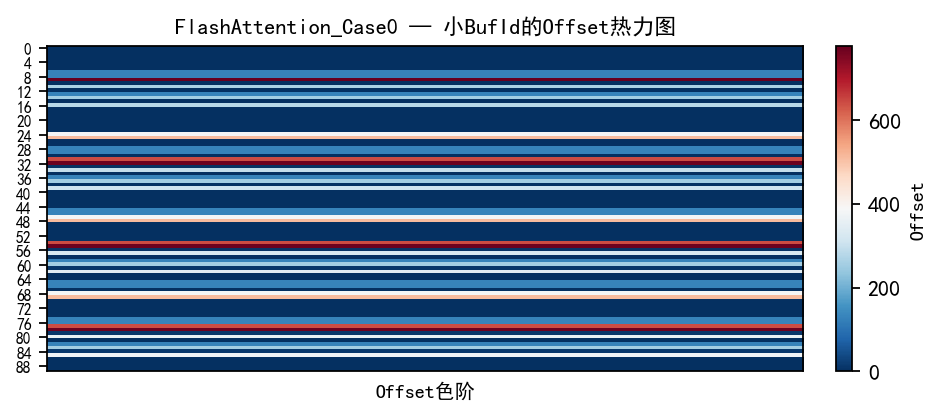

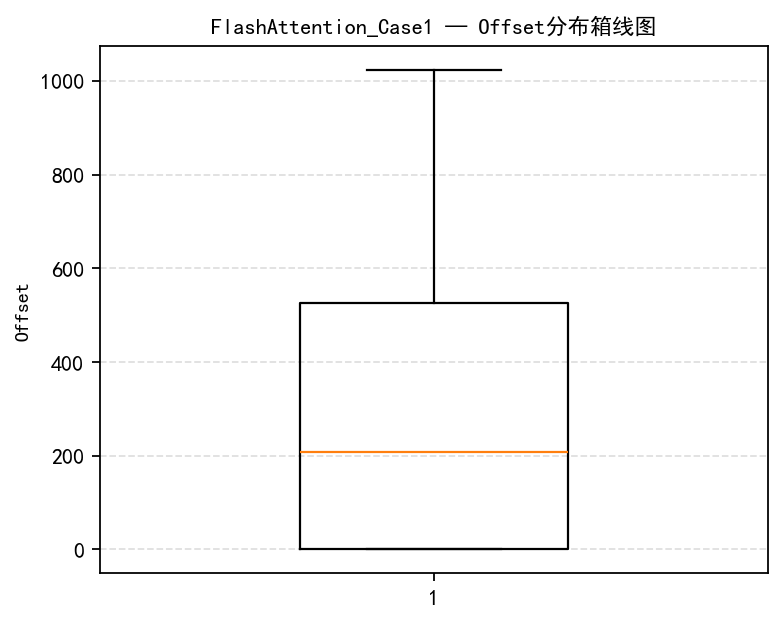

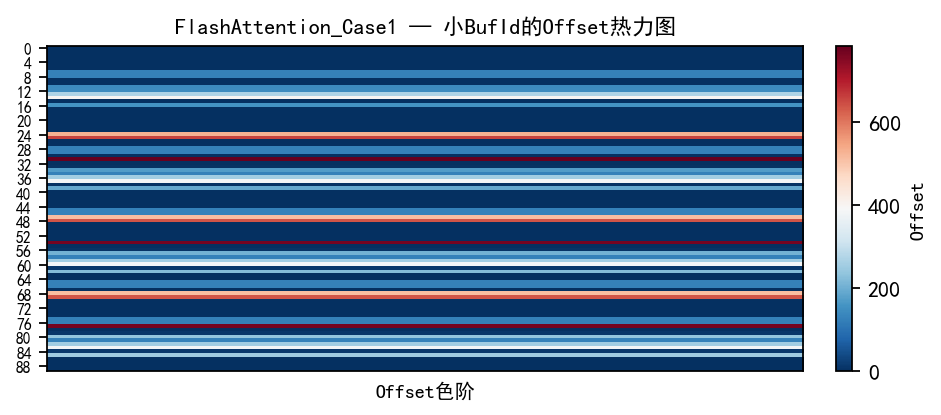

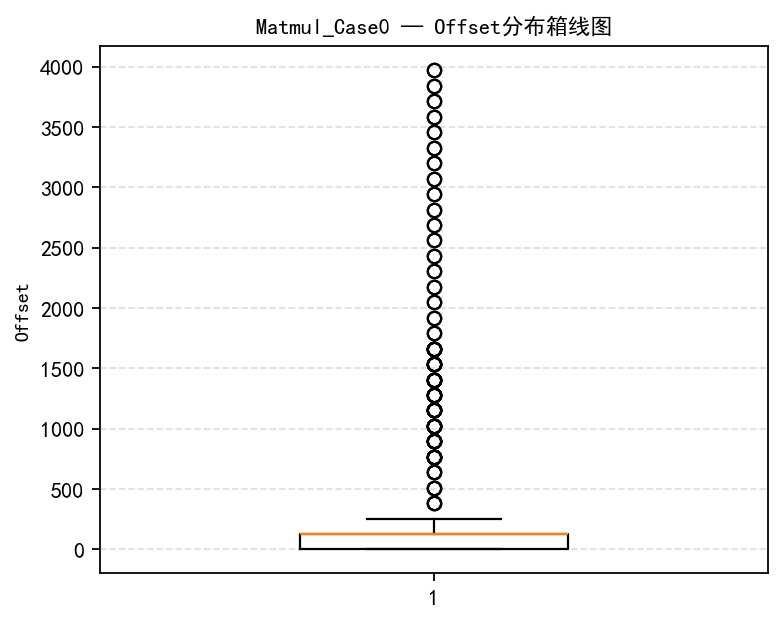

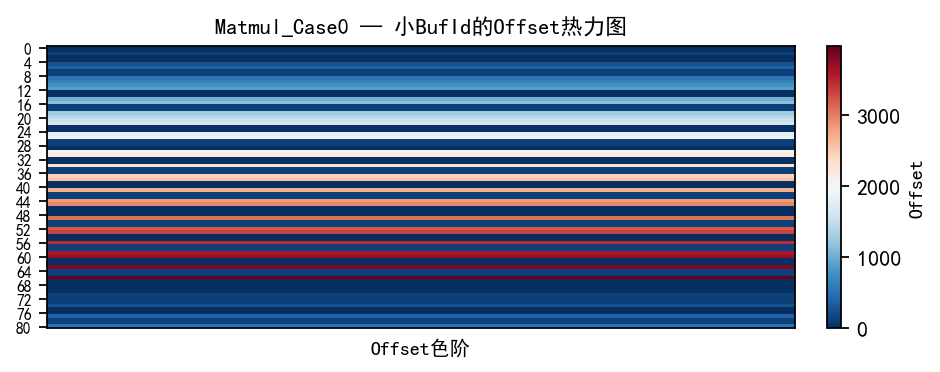

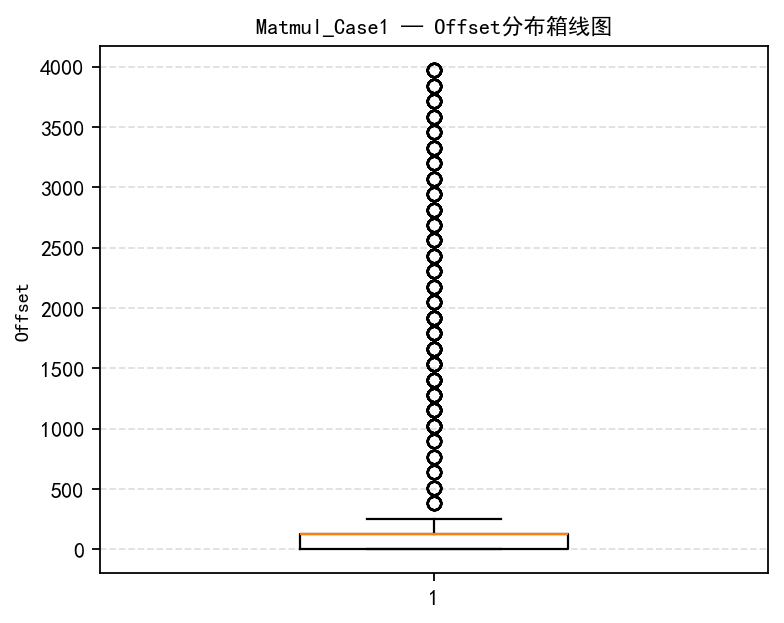

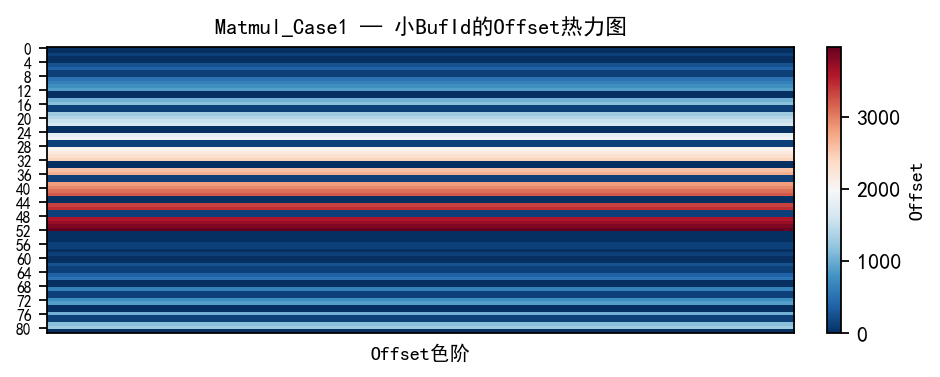

已生成：
 - ./plots\Conv_Case0_offset_boxplot.png
 - ./plots\Conv_Case0_offset_heatmap.png
 - ./plots\Conv_Case1_offset_boxplot.png
 - ./plots\Conv_Case1_offset_heatmap.png
 - ./plots\FlashAttention_Case0_offset_boxplot.png
 - ./plots\FlashAttention_Case0_offset_heatmap.png
 - ./plots\FlashAttention_Case1_offset_boxplot.png
 - ./plots\FlashAttention_Case1_offset_heatmap.png
 - ./plots\Matmul_Case0_offset_boxplot.png
 - ./plots\Matmul_Case0_offset_heatmap.png
 - ./plots\Matmul_Case1_offset_boxplot.png
 - ./plots\Matmul_Case1_offset_heatmap.png


In [2]:
import glob, os
from IPython.display import Image, display

base_dir = r"./"     # 你的Excel目录
out_dir  = os.path.join(base_dir, "plots")
os.makedirs(out_dir, exist_ok=True)

all_png = []
for xlsx in glob.glob(os.path.join(base_dir, "*_memory_analysis.xlsx")):
    outs = plot_for_file(xlsx, out_dir)
    all_png.extend(outs)

# 显示
for p in all_png:
    display(Image(filename=p))

print("已生成：")
for p in all_png:
    print(" -", p)


In [1]:
# -*- coding: utf-8 -*-
"""
q3_app_balanced.py
目标：在保证优化效果的同时大幅降低运行时间
- 单次增强型列表调度（O((N+E) log N)）
- 关键链邻近微调（少量尝试，几乎不占总时长）
- 不改变 Problem2 的 memory/spill，仅等价拓扑重排
- 兼容 PyQt5 / PyQt6
"""
import os, sys, csv, re
from pathlib import Path
from collections import defaultdict, deque
import heapq

# ===================== 可调参数（平衡速度/效果） =====================
# 关键链邻近微调轮数（0/1/2）：2 通常更好且很快；若极端追求速度，设 0
CP_LOCAL_PASSES = 2
# 关键链邻近微调每轮最多尝试次数（上限避免极端大图耗时）
CP_LOCAL_TRY_LIMIT = 256

# ===================== Qt 兼容导入 =====================
try:
    from PyQt5 import QtWidgets, QtCore
    from PyQt5.QtWidgets import (
        QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel,
        QFileDialog, QTableWidget, QTableWidgetItem, QMessageBox, QTextEdit, QSplitter, QSizePolicy, QComboBox
    )
    from PyQt5.QtCore import QObject, pyqtSignal, QThread
    QT_LIB = "PyQt5"
except Exception:
    from PyQt6 import QtWidgets, QtCore
    from PyQt6.QtWidgets import (
        QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel,
        QFileDialog, QTableWidget, QTableWidgetItem, QMessageBox, QTextEdit, QSplitter, QSizePolicy, QComboBox
    )
    from PyQt6.QtCore import QObject, pyqtSignal, QThread
    QT_LIB = "PyQt6"

# ===================== Matplotlib 设置 =====================
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")  # 默认无界面；创建窗口时再尝试 QtAgg

if QT_LIB == "PyQt5":
    from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
else:
    from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

plt.rcParams['font.sans-serif'] = [
    'SimHei', 'Microsoft YaHei', 'PingFang SC', 'Heiti SC',
    'WenQuanYi Micro Hei', 'Noto Sans CJK JP', 'Arial Unicode MS'
]
plt.rcParams['axes.unicode_minus'] = False

APP_TITLE = f"问题三：运行时间优化（均衡版，{QT_LIB}）"

# ===================== 常量 =====================
CAPACITY = {"L1":4096, "UB":1024, "L0A":256, "L0B":256, "L0C":512}
TASKS = [
    "Conv_Case0","Conv_Case1",
    "FlashAttention_Case0","FlashAttention_Case1",
    "Matmul_Case0","Matmul_Case1",
]

# ===================== 基础工具 =====================
def norm_l0_name(x: str) -> str:
    if not x:
        return x
    u = x.strip().upper()
    return u.replace("LOA","L0A").replace("LOB","L0B").replace("LOC","L0C")

def read_nodes_edges(csv_dir: Path, task: str):
    nodes_path = csv_dir / f"{task}_Nodes.csv"
    edges_path = csv_dir / f"{task}_Edges.csv"
    if not nodes_path.exists() or not edges_path.exists():
        raise FileNotFoundError(f"CSV 缺失：{nodes_path} 或 {edges_path}")

    nodes = {}
    buf_attr, op_pipe, cycles = {}, {}, {}
    node_uses = defaultdict(list)
    alloc_node_of, free_node_of = {}, {}
    copyin_uses_buf = set()
    bad_bufs = 0

    with open(nodes_path, newline="", encoding="utf-8") as f:
        for row in csv.DictReader(f):
            nid = int(row["Id"])
            op = (row.get("Op") or "").strip().upper()
            nodes[nid] = row
            p = (row.get("Pipe") or "").strip().upper()
            op_pipe[nid] = norm_l0_name(p) if p else None
            try:
                cycles[nid] = int(row.get("Cycles") or 0)
            except Exception:
                cycles[nid] = 0

            if op == "ALLOC":
                b = int(row["BufId"]); t = norm_l0_name(row.get("Type") or ""); s = int(row["Size"])
                buf_attr[b] = (t, s); alloc_node_of[b] = nid
            elif op == "FREE":
                b = int(row["BufId"]); free_node_of[b] = nid
            else:
                bufs_str = (row.get("Bufs") or "").strip()
                if bufs_str:
                    cleaned = re.sub(r'[\[\]\s"]', '', bufs_str)
                    if cleaned:
                        for tok in cleaned.split(','):
                            if not tok: continue
                            try:
                                b = int(tok)
                                node_uses[nid].append(b)
                                if op == "COPY_IN":
                                    copyin_uses_buf.add(b)
                            except Exception:
                                bad_bufs += 1

    edges = []
    with open(edges_path, newline="", encoding="utf-8") as f:
        for row in csv.DictReader(f):
            u, v = int(row["StartNodeId"]), int(row["EndNodeId"])
            edges.append((u, v))

    n_max = max(nodes.keys()) if nodes else -1
    meta = {
        "nodes": nodes, "edges": edges, "buf_attr": buf_attr, "op_pipe": op_pipe,
        "cycles": cycles, "node_uses": node_uses,
        "alloc_node_of": alloc_node_of, "free_node_of": free_node_of,
        "copyin_uses_buf": copyin_uses_buf, "N": n_max + 1
    }
    if bad_bufs:
        print(f"[warn] 跳过 {bad_bufs} 个非法 Bufs 令牌")
    return meta

def read_problem_schedule(dir_path: Path, task: str, _tag_unused: str = ""):
    sch_path = dir_path / f"{task}_schedule.txt"
    if not sch_path.exists():
        return None
    seq = []
    with open(sch_path, "r", encoding="utf-8") as f:
        for ln in f:
            s = ln.strip()
            if s:
                try:
                    seq.append(int(s))
                except Exception:
                    pass
    return seq

def read_memory(dir_path: Path, task: str):
    m_path = dir_path / f"{task}_memory.txt"
    if not m_path.exists():
        return {}
    mem = {}
    with open(m_path, "r", encoding="utf-8") as f:
        for ln in f:
            s = ln.strip()
            if not s: continue
            if ":" in s:
                b, off = s.split(":", 1)
                try:
                    mem[int(b)] = int(off)
                except Exception:
                    pass
    return mem

def read_spill(dir_path: Path, task: str):
    sp_path = dir_path / f"{task}_spill.txt"
    if not sp_path.exists():
        return []
    ops = []
    with open(sp_path, "r", encoding="utf-8") as f:
        for ln in f:
            s = ln.strip()
            if not s: continue
            if ":" in s:
                b, off = s.split(":", 1)
                try:
                    ops.append((int(b), int(off)))
                except Exception:
                    pass
    return ops

def ensure_dirs(root_path: Path):
    csv_dir = root_path / "CSV版本"
    p1_dir = root_path / "Problem1"
    p2_dir = root_path / "Problem2"
    p3_dir = root_path / "Problem3"

    missing_dirs = []
    if not csv_dir.exists(): missing_dirs.append("CSV版本")
    if not p1_dir.exists(): missing_dirs.append("Problem1")
    if not p2_dir.exists(): missing_dirs.append("Problem2")
    if missing_dirs:
        raise FileNotFoundError(
            f"所选目录 '{root_path}' 缺少以下必需的子目录: {', '.join(missing_dirs)}"
        )
    p3_dir.mkdir(parents=True, exist_ok=True)
    return csv_dir, p1_dir, p2_dir, p3_dir

# ===================== 图与调度（高效） =====================
def build_graph(N, edges):
    adj = defaultdict(list)
    indeg = [0]*N
    pred = defaultdict(list)
    for u, v in edges:
        if 0 <= u < N and 0 <= v < N:
            adj[u].append(v)
            pred[v].append(u)
            indeg[v] += 1
    return adj, indeg, pred

def compute_longest_path_to_sink(N, adj, w):
    radj = defaultdict(list)
    outdeg = [0]*N
    for u in range(N):
        for v in adj[u]:
            radj[v].append(u)
            outdeg[u] += 1
    q = deque([u for u in range(N) if outdeg[u] == 0])
    dist = [0]*N
    while q:
        v = q.popleft()
        for u in radj[v]:
            nv = dist[v] + w[v]
            if dist[u] < nv:
                dist[u] = nv
            outdeg[u] -= 1
            if outdeg[u] == 0:
                q.append(u)
    for v in range(N):
        dist[v] += w[v]
    return dist

def compute_es_ls_slack(N, adj, pred, cycles):
    indeg0 = [0]*N
    for v in range(N):
        for u in pred[v]:
            indeg0[v] += 1
    q = deque([v for v in range(N) if indeg0[v] == 0])
    topo = []
    while q:
        v = q.popleft()
        topo.append(v)
        for w in adj[v]:
            indeg0[w] -= 1
            if indeg0[w] == 0:
                q.append(w)

    ES = [0]*N
    EF = [0]*N
    for v in topo:
        es = 0
        for u in pred[v]:
            if EF[u] > es:
                es = EF[u]
        ES[v] = es
        dur = cycles.get(v, 0)
        if dur < 0: dur = 0
        EF[v] = es + dur

    EF_max = max(EF) if EF else 0
    LF = [EF_max]*N; LS = [0]*N
    for v in reversed(topo):
        if adj[v]:
            LF[v] = min(LS[w] for w in adj[v])
        dur = cycles.get(v, 0)
        if dur < 0: dur = 0
        LS[v] = LF[v] - dur
    slack = [LS[v] - ES[v] for v in range(N)]
    return ES, LS, slack, EF_max

def evaluate_makespan(order, adj, indeg0, pred, pipe_of, cycles):
    N = len(indeg0)
    if N == 0:
        return 0, [], [], defaultdict(list)
    S = [0]*N; E = [0]*N; pipe_ready = defaultdict(int)
    for v in order:
        if not (0 <= v < N): continue
        pr = pipe_of.get(v)
        start_ready = pipe_ready[pr] if pr else 0
        dep_ready = 0
        for u in pred[v]:
            if E[u] > dep_ready:
                dep_ready = E[u]
        start = start_ready if start_ready > dep_ready else dep_ready
        dur = cycles.get(v, 0);  dur = max(0, dur)
        S[v] = start; E[v] = start + dur
        if pr:
            pipe_ready[pr] = E[v]
    total = max(E) if E else 0
    per_pipe_segments = defaultdict(list)
    for v in order:
        if 0 <= v < N:
            p = pipe_of.get(v) or "NONE"
            d = cycles.get(v, 0)
            if d > 0:
                per_pipe_segments[p].append((S[v], d, v))
    return total, S, E, per_pipe_segments

def q3_reschedule_fast(N, edges, base_order, pipe_of, cycles):
    """
    高速增强型列表调度（一次成型，O((N+E) log N)）
    评分 = (finish_time, -crit, slack, gap_penalty, -down_gain, base_idx)
    """
    adj, indeg, pred = build_graph(N, edges)
    w = [cycles.get(i, 0) for i in range(N)]
    crit = compute_longest_path_to_sink(N, adj, w)
    ES, LS, slack, _ = compute_es_ls_slack(N, adj, pred, cycles)

    # 下游关键度一跳平均
    down_gain = [0]*N
    for v in range(N):
        if adj[v]:
            s = 0
            for wv in adj[v]:
                s += crit[wv]
            down_gain[v] = s / len(adj[v])

    indeg_now = indeg[:]
    ready = {v for v in range(N) if indeg_now[v] == 0}
    base_pos = {v: i for i, v in enumerate(base_order) if 0 <= v < N}
    pipe_ready = defaultdict(int)

    S = [0]*N; E = [0]*N
    schedule = []; picked = set()

    def push_all(h):
        for v in list(ready):
            if v in picked: continue
            dep_ready = 0
            for u in pred[v]:
                if E[u] > dep_ready:
                    dep_ready = E[u]
            pr = pipe_of.get(v)
            pr_ready = pipe_ready[pr] if pr else 0
            start = pr_ready if pr_ready > dep_ready else dep_ready
            dur = max(0, cycles.get(v, 0))
            finish = start + dur
            node_slack = slack[v] if v < len(slack) else 0
            gap_penalty = max(0, start - dep_ready)
            dg = down_gain[v]
            heapq.heappush(
                h,
                (finish, -crit[v], node_slack, gap_penalty, -dg, base_pos.get(v, 1<<30),
                 start, v, pr, dur)
            )

    while ready:
        heap = []
        push_all(heap)
        if not heap: break
        _, _, _, _, _, _, start, v, pr, dur = heapq.heappop(heap)
        schedule.append(v); picked.add(v)
        S[v] = start; E[v] = start + dur
        if pr: pipe_ready[pr] = E[v]
        ready.discard(v)
        for wv in adj[v]:
            indeg_now[wv] -= 1
            if indeg_now[wv] == 0:
                ready.add(wv)

    extra = [x for x in base_order if (x < 0 or x >= N)]
    return schedule + extra, pred, crit

# -------- 关键链邻近微调（少量） --------
def extract_critical_chain_by_E(E, pred):
    """基于已调度的 E，从最大 E 的节点回溯，选取每步 E[u] 最大的前驱，形成近似关键链。"""
    if not E: return []
    sink = max(range(len(E)), key=lambda i: E[i])
    chain = [sink]
    v = sink
    seen = set(chain)
    # 为了线性时间，步数不会超过 N
    for _ in range(len(E)):
        ps = pred[v]
        if not ps: break
        u = max(ps, key=lambda x: E[x])
        if u in seen: break
        chain.append(u); seen.add(u); v = u
    chain.reverse()
    return chain  # 从源向汇的顺序

def improve_by_cp_adjacent_swaps(order, adj, indeg, pred, pipe_of, cycles,
                                 passes=2, try_limit=256):
    """
    仅围绕“当前关键链”做相邻合法交换（拓扑可行），少量尝试。
    - 每轮：按当前 E 取关键链 -> 沿链从早到晚，尝试与前一位互换（若无边 a->b），若 makespan 下降则接受
    - 次数严格上限，几乎不影响总时长
    """
    if not order: return order
    N = len(indeg)
    # 快速边判断
    edge_direct = set()
    for u in range(N):
        for v in adj[u]:
            edge_direct.add((u, v))

    def legal_swap(a, b):
        return (a, b) not in edge_direct  # 有 a->b 则不可换

    best_order = order[:]
    best_T, _, E, _ = evaluate_makespan(best_order, adj, indeg, pred, pipe_of, cycles)

    for _ in range(max(0, passes)):
        tries = 0
        chain = extract_critical_chain_by_E(E, pred)
        if not chain or tries >= try_limit:
            break

        # 建索引：node -> 在当前顺序的位置
        pos = {v: i for i, v in enumerate(best_order)}
        improved_round = False

        for node in chain:
            if tries >= try_limit: break
            j = pos.get(node, None)
            if j is None or j == 0:  # 已在最前或不存在
                continue
            a = best_order[j-1]; b = best_order[j]
            if not (0 <= a < N and 0 <= b < N):
                continue
            if not legal_swap(a, b):
                continue
            # 尝试交换
            best_order[j-1], best_order[j] = b, a
            T2, _, E2, _ = evaluate_makespan(best_order, adj, indeg, pred, pipe_of, cycles)
            tries += 1
            if T2 < best_T:
                # 接受改进
                best_T = T2; E = E2
                pos[a], pos[b] = j, j-1
                improved_round = True
            else:
                # 恢复
                best_order[j-1], best_order[j] = a, b

        if not improved_round:
            # 当前关键链已无法邻近改良
            break
    return best_order

def write_problem3(p3_dir: Path, task: str, schedule, memory_map, spill_ops):
    p3_dir.mkdir(parents=True, exist_ok=True)
    with open(p3_dir / f"{task}_schedule.txt", "w", encoding="utf-8") as f:
        for x in schedule: f.write(str(x) + "\n")
    with open(p3_dir / f"{task}_memory.txt", "w", encoding="utf-8") as f:
        for b in sorted(memory_map.keys()):
            f.write(f"{b}:{memory_map[b]}\n")
    with open(p3_dir / f"{task}_spill.txt", "w", encoding="utf-8") as f:
        for b, off in spill_ops: f.write(f"{b}:{off}\n")

# ===================== 绘图 =====================
class MplCanvas(FigureCanvas):
    def __init__(self, width=8.4, height=5.6, dpi=100):
        self.fig = Figure(figsize=(width, height), dpi=dpi)
        super().__init__(self.fig)

def pipe_utilization(segments, makespan):
    util = {}
    for p, segs in segments.items():
        busy = sum(d for _, d, _ in segs)
        util[p] = (busy / makespan) if makespan > 0 else 0.0
    return util

def sort_pipes_for_plot(seg_dict):
    pipes = list(seg_dict.keys())
    def key(p):
        return (1, p) if p == "NONE" else (0, p or "")
    return sorted(pipes, key=key)

def draw_gantt(ax, segments, title="甘特图", highlight_nodes=None, show_all_node_labels=False,
               bar_color="#E53935", highlight_color="#000000", dark_bg=False):
    """
    红黑配色甘特图：
    - 普通段：红色
    - 高亮段：黑色（文字自动白色）
    - 网格/坐标轴：黑色
    - 若 dark_bg=True，则改用黑色背景与白色刻度文字
    """
    # ---- 主题色 ----
    bg_color   = "#000000" if dark_bg else "#FFFFFF"
    axis_color = "#FFFFFF" if dark_bg else "#000000"
    grid_color = "#FFFFFF" if dark_bg else "#000000"
    text_color = axis_color

    ax.set_facecolor(bg_color)
    for spine in ax.spines.values():
        spine.set_color(axis_color)

    pipes = sort_pipes_for_plot(segments)
    if not pipes:
        ax.text(0.5, 0.5, "无任务段", ha="center", va="center", transform=ax.transAxes, color=text_color)
        ax.set_axis_off()
        return

    yticks, yticklabels = [], []
    pipe_y_map = {pipe: i for i, pipe in enumerate(pipes)}
    max_t = 0

    for p in pipes:
        y = pipe_y_map[p]
        spans = sorted(segments[p], key=lambda x: x[0])
        for (st, du, nid) in spans:
            is_hl = bool(highlight_nodes and (nid in highlight_nodes))
            face = highlight_color if is_hl else bar_color
            ax.broken_barh([(st, du)], (y - 0.4, 0.8),
                           facecolors=face, edgecolor="#000000", linewidth=0.8)

            # 只有长度足够时才标注；高亮段文字用白色，其余用黑/白随主题
            show_label = (show_all_node_labels and du > 0.01 * (ax.get_xlim()[1] if ax.get_xlim()[1] > 0 else 1)) \
                         or is_hl
            if show_label:
                lab_color = "#FFFFFF" if is_hl or dark_bg else "#000000"
                ax.text(st + du / 2, y,
                        f"{'*' if is_hl else ''}{nid}",
                        ha="center", va="center", fontsize=7, color=lab_color)
            max_t = max(max_t, st + du)

        yticks.append(y); yticklabels.append(p)

    ax.set_yticks(yticks); ax.set_yticklabels(yticklabels, color=text_color)
    ax.set_ylim(-1, len(pipes)); ax.set_xlim(0, max_t if max_t > 0 else 1)
    ax.set_xlabel("周期", color=text_color); ax.set_title(title, color=text_color)

    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    ax.grid(True, axis="x", linestyle="--", linewidth=0.6, alpha=0.5, color=grid_color)


def draw_util(ax, util_dict_p2, util_dict_p3, title="管线利用率",
              p2_color="#6C67FF", p3_color="#10DF6A", edge="#1A1A1A", dark_bg=False):
    # 主题外观（可选暗色背景）
    bg = "#000000" if dark_bg else "#FFFFFF"
    fg = "#FFFFFF" if dark_bg else "#000000"
    ax.set_facecolor(bg)
    for s in ax.spines.values(): s.set_color(fg)

    pipes = sorted(list(set(util_dict_p2.keys()) | set(util_dict_p3.keys())))
    if not pipes:
        ax.text(0.5, 0.5, "无管线", ha="center", va="center", transform=ax.transAxes, color=fg)
        ax.set_axis_off(); return

    x = list(range(len(pipes))); w = 0.35
    p2_vals = [util_dict_p2.get(p, 0.0) for p in pipes]
    p3_vals = [util_dict_p3.get(p, 0.0) for p in pipes]

    ax.bar([i - w/2 for i in x], p2_vals, width=w, label="P2",
           color=p2_color, edgecolor=edge, linewidth=0.8)
    ax.bar([i + w/2 for i in x], p3_vals, width=w, label="P3",
           color=p3_color, edgecolor=edge, linewidth=0.8)

    ax.set_xticks(x); ax.set_xticklabels(pipes, color=fg)
    ax.set_ylim(0, 1.05); ax.set_ylabel("利用率", color=fg); ax.set_title(title, color=fg)
    ax.tick_params(axis="y", colors=fg)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.6, color=fg)
    ax.legend(facecolor=bg, edgecolor=fg, labelcolor=fg)


def draw_time_compare(ax, p2, p3, task_name="任务",
                      p2_color="#6C67FF", p3_color="#10DF6A",
                      edge="#1A1A1A", dark_bg=False, grid_alpha=0.6):
    # 主题外观（与 draw_util 保持一致）
    bg = "#000000" if dark_bg else "#FFFFFF"
    fg = "#FFFFFF" if dark_bg else "#000000"
    ax.set_facecolor(bg)
    for s in ax.spines.values():
        s.set_color(fg)

    # 柱状图（配色与描边一致）
    ax.bar([0], [p2], width=0.6, label="P2",
           color=p2_color, edgecolor=edge, linewidth=0.8)
    ax.bar([1], [p3], width=0.6, label="P3",
           color=p3_color, edgecolor=edge, linewidth=0.8)

    ax.set_xticks([0, 1]); ax.set_xticklabels(["P2", "P3"], color=fg)
    ax.set_ylabel("周期", color=fg)
    ax.set_title(f"{task_name} - 总时间对比", color=fg)
    ax.tick_params(axis="y", colors=fg)

    # 网格风格与 draw_util 一致
    ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=grid_alpha, color=fg)

    # 图例风格与 draw_util 一致
    ax.legend(facecolor=bg, edgecolor=fg, labelcolor=fg)


def draw_criticality(ax, crit_values, title="节点关键度（距离终点距离）",
                     bar_color="#F3123F", edge="#B36F6F",
                     dark_bg=False, grid_alpha=0.18):
    # 主题外观
    bg = "#000000" if dark_bg else "#FFFFFF"
    fg = "#FFFFFF" if dark_bg else "#000000"
    ax.set_facecolor(bg)
    for s in ax.spines.values(): s.set_color(fg)

    if not crit_values:
        ax.text(0.5, 0.5, "无节点", ha="center", va="center",
                transform=ax.transAxes, color=fg)
        ax.set_axis_off(); return

    valid_nodes = [i for i, val in enumerate(crit_values) if val > 0]
    if not valid_nodes:
        ax.text(0.5, 0.5, "无可关键路径节点", ha="center", va="center",
                transform=ax.transAxes, color=fg)
        ax.set_axis_off(); return

    valid_crit = [crit_values[i] for i in valid_nodes]

    ax.bar(valid_nodes, valid_crit,
           color=bar_color, edgecolor=edge, linewidth=0.8)

    if len(valid_nodes) < 50:
        ax.set_xticks(valid_nodes)
    else:
        ax.set_xticks([])

    ax.set_xlabel("节点 ID", color=fg)
    ax.set_ylabel("关键度", color=fg)
    ax.set_title(title, color=fg)
    ax.tick_params(axis="x", colors=fg)
    ax.tick_params(axis="y", colors=fg)

    grid_color = "#D9D9D9" if not dark_bg else "#FFFFFF"
    ax.grid(True, axis="y", linestyle="--", linewidth=0.6,
            alpha=grid_alpha, color=grid_color)


# ===================== 任务求解封装 =====================
def solve_task_q3(root: Path, task: str):
    csv_dir, p1_dir, p2_dir, p3_dir = ensure_dirs(root)
    meta = read_nodes_edges(csv_dir, task)
    N, edges = meta["N"], meta["edges"]
    pipe_of, cycles = meta["op_pipe"], meta["cycles"]

    p2_schedule = read_problem_schedule(p2_dir, task, "2")
    p1_schedule = read_problem_schedule(p1_dir, task, "1")
    base_schedule = p2_schedule if p2_schedule else (p1_schedule if p1_schedule else list(range(N)))

    mem_map = read_memory(p2_dir, task)
    spill_ops = read_spill(p2_dir, task)

    adj, indeg, pred = build_graph(N, edges)
    base_order = [x for x in base_schedule if 0 <= x < N]
    p2_time, S2, E2, seg2 = evaluate_makespan(base_order, adj, indeg, pred, pipe_of, cycles)

    # 1) 高速增强型列表调度（一次）
    new_order, pred_used, crit = q3_reschedule_fast(N, edges, base_order, pipe_of, cycles)

    # 2) 关键链邻近微调（少量尝试，严格上限）
    improved_order = improve_by_cp_adjacent_swaps(
        [x for x in new_order if 0 <= x < N],
        adj, indeg, pred_used,
        pipe_of, cycles,
        passes=CP_LOCAL_PASSES,
        try_limit=CP_LOCAL_TRY_LIMIT
    )

    # 评估并写回
    p3_time, S3, E3, seg3 = evaluate_makespan(improved_order, adj, indeg, pred_used, pipe_of, cycles)
    final_schedule = improved_order + [x for x in new_order if (x < 0 or x >= N)]
    write_problem3(p3_dir, task, final_schedule, mem_map, spill_ops)

    return {
        "task": task,
        "p2_time": int(p2_time),
        "p3_time": int(p3_time),
        "improve": int(p2_time) - int(p3_time),
        "p3_schedule_len": len(final_schedule),
        "p2_schedule_len": len(base_schedule) if base_schedule else 0,
        "p2_used": True if p2_schedule else False,
        "p3_dir": str(p3_dir),

        "N": N,
        "pipes": sorted(list(set(p for p in pipe_of.values() if p is not None))),
        "seg_p2": seg2,
        "seg_p3": seg3,
        "S2": S2, "E2": E2,
        "S3": S3, "E3": E3,
        "pipe_of": pipe_of,
        "cycles": cycles,
        "crit": crit,
        "order_p2": base_order,
        "order_p3": [x for x in final_schedule if 0 <= x < N],
    }

def build_typora_md(results):
    md = []
    md.append("## 问题三：在不显著增加总额外数据搬运量前提下降低总运行时间（均衡版）\n")
    md.append("### 方法\n")
    md.append("- 一次增强型列表调度：min finish + 关键度/Slack/下游关键度/空转惩罚\n")
    md.append("- 关键链邻近微调：仅围绕关键链做少量相邻交换，极低开销\n")
    md.append("\n### 六个算例的时间对比（单位：周期）\n")
    md.append("| 任务 | 基线是否用P2 | P2总时间 | P3总时间 | 改善 | P2序列长 | P3序列长 |\n|---|---:|---:|---:|---:|---:|---:|\n")
    for r in results:
        md.append(f"| {r['task']} | {'是' if r['p2_used'] else '否'} | {r['p2_time']} | {r['p3_time']} | {r['improve']} | {r['p2_schedule_len']} | {r['p3_schedule_len']} |\n")
    md.append("\n> 注：输出在 `Problem3/`，沿用 Problem2 的 memory/spill，不新增搬运。\n")
    return "".join(md)

# ===================== 导出线程 =====================
class PlotExporterWorker(QObject):
    finished = pyqtSignal()
    error = pyqtSignal(str)
    progress = pyqtSignal(str)

    def __init__(self, results, output_base_dir):
        super().__init__()
        self.results = results
        self.output_base_dir = output_base_dir

    def run(self):
        try:
            self.output_base_dir.mkdir(parents=True, exist_ok=True)
            for i, r in enumerate(self.results):
                self.progress.emit(f"任务 {r['task']}: 正在导出图表 ({i+1}/{len(self.results)})...")
                task_out_dir = self.output_base_dir / r["task"]
                task_out_dir.mkdir(parents=True, exist_ok=True)

                crit = r["crit"]
                non_zero_crit_nodes = [i_node for i_node, c in enumerate(crit) if c > 0]
                K = min(10, len(non_zero_crit_nodes))
                top_idx = set(sorted(non_zero_crit_nodes, key=lambda i_node: crit[i_node], reverse=True)[:K])

                # P2 甘特图
                try:
                    fig = Figure(figsize=(12, 6), dpi=120)
                    ax = fig.add_subplot(111)
                    draw_gantt(ax, r["seg_p2"], title=f"{r['task']} - P2 甘特图", highlight_nodes=top_idx, show_all_node_labels=False)
                    fig.tight_layout(); fig.savefig(task_out_dir / f"{r['task']}_P2_Gantt.png")
                except Exception as plot_err:
                    self.progress.emit(f"  [警告] 导出 {r['task']} P2 甘特图失败: {plot_err}")
                finally:
                    plt.close('all')

                # P3 甘特图
                try:
                    fig = Figure(figsize=(12, 6), dpi=120)
                    ax = fig.add_subplot(111)
                    draw_gantt(ax, r["seg_p3"], title=f"{r['task']} - P3 甘特图", highlight_nodes=top_idx, show_all_node_labels=False)
                    fig.tight_layout(); fig.savefig(task_out_dir / f"{r['task']}_P3_Gantt.png")
                except Exception as plot_err:
                    self.progress.emit(f"  [警告] 导出 {r['task']} P3 甘特图失败: {plot_err}")
                finally:
                    plt.close('all')

                # 管线利用率
                try:
                    makespan_p2 = max(r["E2"]) if r["E2"] else 1
                    makespan_p3 = max(r["E3"]) if r["E3"] else 1
                    util2 = pipe_utilization(r["seg_p2"], makespan_p2)
                    util3 = pipe_utilization(r["seg_p3"], makespan_p3)
                    fig = Figure(figsize=(8, 5), dpi=120)
                    ax = fig.add_subplot(111)
                    draw_util(ax, util2, util3, title=f"{r['task']} - 管线利用率")
                    fig.tight_layout(); fig.savefig(task_out_dir / f"{r['task']}_Utilization.png")
                except Exception as plot_err:
                    self.progress.emit(f"  [警告] 导出 {r['task']} 管线利用率图失败: {plot_err}")
                finally:
                    plt.close('all')

                # 总时间对比
                try:
                    fig = Figure(figsize=(6, 4), dpi=120)
                    ax = fig.add_subplot(111)
                    draw_time_compare(ax, r["p2_time"], r["p3_time"], r["task"])
                    fig.tight_layout(); fig.savefig(task_out_dir / f"{r['task']}_TimeCompare.png")
                except Exception as plot_err:
                    self.progress.emit(f"  [警告] 导出 {r['task']} 总时间对比图失败: {plot_err}")
                finally:
                    plt.close('all')

                # 关键度
                try:
                    fig = Figure(figsize=(12, 5), dpi=120)
                    ax = fig.add_subplot(111)
                    draw_criticality(ax, crit, title=f"{r['task']} - 节点关键度（距离终点距离）")
                    fig.tight_layout(); fig.savefig(task_out_dir / f"{r['task']}_Criticality.png")
                except Exception as plot_err:
                    self.progress.emit(f"  [警告] 导出 {r['task']} 节点关键度图失败: {plot_err}")
                finally:
                    plt.close('all')

            self.finished.emit()
        except Exception as e:
            self.error.emit(f"导出图表时发生整体错误：{e}")
        finally:
            self.progress.emit("所有图表导出过程完成。")

# ===================== 主窗口 =====================
class MplCanvas(FigureCanvas):
    def __init__(self, width=8.4, height=5.6, dpi=100):
        self.fig = Figure(figsize=(width, height), dpi=dpi)
        super().__init__(self.fig)

class MainWin(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle(APP_TITLE); self.resize(1200, 760)

        w = QWidget(); self.setCentralWidget(w)
        main = QVBoxLayout(w)

        top = QHBoxLayout()
        self.btn_pick = QPushButton("选择根目录（含 CSV版本/、Problem1/、Problem2/）")
        self.btn_run = QPushButton("运行问题三（全部算例）")
        self.btn_copy = QPushButton("复制论文段落（Typora）")
        self.btn_export = QPushButton("导出全部图（PNG）")
        top.addWidget(self.btn_pick); top.addWidget(self.btn_run)
        top.addStretch(1); top.addWidget(self.btn_copy); top.addWidget(self.btn_export)
        main.addLayout(top)

        self.lbl = QLabel("根目录：未选择"); main.addWidget(self.lbl)

        splitter = QSplitter()
        left = QWidget(); left_layout = QVBoxLayout(left)

        self.table = QTableWidget(0, 7)
        self.table.setHorizontalHeaderLabels(["任务","是否用P2","P2总时间","P3总时间","改善","P2序列长","P3序列长"])
        self.table.horizontalHeader().setStretchLastSection(True)
        left_layout.addWidget(self.table)

        self.log = QTextEdit(); self.log.setReadOnly(True); left_layout.addWidget(self.log)
        splitter.addWidget(left)

        right = QWidget(); right_layout = QVBoxLayout(right)
        opt_line = QHBoxLayout()
        self.cmb_which = QComboBox()
        self.cmb_which.addItems(["甘特图：P2","甘特图：P3","管线利用率 P2 vs P3","总时间对比","关键度（近似CP）"])
        self.btn_draw = QPushButton("可视化所选任务")
        opt_line.addWidget(self.cmb_which); opt_line.addStretch(1); opt_line.addWidget(self.btn_draw)
        right_layout.addLayout(opt_line)

        self.canvas = MplCanvas(width=8.4, height=5.6, dpi=100)
        if QT_LIB == "PyQt6":
            self.canvas.setSizePolicy(QSizePolicy.Policy.Expanding, QSizePolicy.Policy.Expanding)
        else:
            self.canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        right_layout.addWidget(self.canvas)

        splitter.addWidget(right); splitter.setStretchFactor(0, 2); splitter.setStretchFactor(1, 3)
        main.addWidget(splitter)

        self.root = Path(os.getcwd())
        self.csv_dir = self.p1_dir = self.p2_dir = self.p3_dir = None
        self.results = []

        self.exporter_thread = None; self.exporter_worker = None

        self.btn_pick.clicked.connect(self.on_pick)
        self.btn_run.clicked.connect(self.on_run)
        self.btn_copy.clicked.connect(self.on_copy)
        self.btn_export.clicked.connect(self.on_export_all)
        self.btn_draw.clicked.connect(self.on_draw_selected)
        self.table.cellClicked.connect(self.on_table_clicked)

        self.auto_locate()

    def auto_locate(self):
        try:
            csv_dir, p1_dir, p2_dir, p3_dir = ensure_dirs(self.root)
            self.csv_dir, self.p1_dir, self.p2_dir, self.p3_dir = csv_dir, p1_dir, p2_dir, p3_dir
            self.lbl.setText(f"根目录: {self.root}\n  CSV版本: {csv_dir.name}\n  Problem1: {p1_dir.name}\n  Problem2: {p2_dir.name}\n  Problem3(输出): {p3_dir.name}")
            self.log.append(f"[信息] 成功自动定位根目录: {self.root}")
        except FileNotFoundError as e:
            self.csv_dir = self.p1_dir = self.p2_dir = self.p3_dir = None
            self.lbl.setText("根目录：未选择 (当前工作目录不符合要求)")
            self.log.append(f"[警告] 自动定位失败：{e}\n请手动选择正确的根目录。")
        except Exception as e:
            self.csv_dir = self.p1_dir = self.p2_dir = self.p3_dir = None
            self.lbl.setText("根目录：未选择 (发生错误)")
            self.log.append(f"[错误] 自动定位时发生未知错误：{e}")

    def on_pick(self):
        try:
            initial_path = str(self.root) if self.root.exists() else os.getcwd()
            d = QFileDialog.getExistingDirectory(self, "选择根目录（包含 CSV版本/, Problem1/, Problem2/, Problem3/）", initial_path)
            if d:
                selected_root = Path(d)
                csv_dir, p1_dir, p2_dir, p3_dir = ensure_dirs(selected_root)
                self.root = selected_root
                self.csv_dir, self.p1_dir, self.p2_dir, self.p3_dir = csv_dir, p1_dir, p2_dir, p3_dir
                self.lbl.setText(f"根目录: {self.root}\n  CSV版本: {csv_dir.name}\n  Problem1: {p1_dir.name}\n  Problem2: {p2_dir.name}\n  Problem3(输出): {p3_dir.name}")
                self.log.append(f"[信息] 成功手动选择根目录: {self.root}")
                self.table.setRowCount(0); self.results = []
                self.canvas.fig.clf(); self.canvas.draw_idle()
            else:
                self.log.append("[信息] 用户取消了目录选择。")
        except FileNotFoundError as e:
            QMessageBox.critical(self, "错误", f"所选目录不符合要求：\n{e}\n请确保所选目录包含所有必需的子目录。")
            self.log.append(f"[错误] 目录选择失败：{e}")
            self.csv_dir = self.p1_dir = self.p2_dir = self_p3_dir = None
            self.lbl.setText("根目录：未选择 (所选目录不符合要求)")
        except Exception as e:
            QMessageBox.critical(self, "错误", f"选择目录时发生未知错误：\n{e}")
            self.log.append(f"[错误] 选择目录失败：{e}")

    def on_run(self):
        if not (self.csv_dir and self.p1_dir and self.p2_dir and self.p3_dir):
            QMessageBox.warning(self, "提示", "请先选择并验证根目录（确保包含 CSV版本/ Problem1/ Problem2/）。")
            return
        self.table.setRowCount(0); self.results = []; total_imp = 0
        self._set_ui_enabled_state(False)
        try:
            for t in TASKS:
                self.log.append(f"正在处理任务: {t}...")
                QApplication.processEvents()
                r = solve_task_q3(self.root, t)
                self.results.append(r); self.append_row(r)
                self.log.append(f"[完成] {t}: P2={r['p2_time']}, P3={r['p3_time']}, 改善={r['improve']}")
                QApplication.processEvents()
                total_imp += r["improve"]
            self.log.append(f"\n[汇总] 总改善：{total_imp} 周期。输出目录：{self.p3_dir}")
            QMessageBox.information(self, "完成", f"问题三全部算例完成！总改善：{total_imp} 周期。\n已输出到：{self.p3_dir}")
        except Exception as e:
            QMessageBox.critical(self, "错误", f"运行失败：\n{e}")
            self.log.append(f"[错误] 运行失败：{e}")
        finally:
            self._set_ui_enabled_state(True)

    def append_row(self, r):
        row = self.table.rowCount(); self.table.insertRow(row)
        def setc(c, text): self.table.setItem(row, c, QTableWidgetItem(str(text)))
        setc(0, r["task"])
        setc(1, "是" if r["p2_used"] else "否")
        setc(2, r["p2_time"])
        setc(3, r["p3_time"])
        setc(4, r["improve"])
        setc(5, r["p2_schedule_len"])
        setc(6, r["p3_schedule_len"])

    def on_copy(self):
        if not self.results:
            QMessageBox.information(self, "提示", "请先运行问题三，生成结果后再复制。")
            return
        md = build_typora_md(self.results)
        cb = QApplication.clipboard(); cb.setText(md)
        QMessageBox.information(self, "已复制", "论文段落（Typora Markdown）已复制到剪贴板 ✅")

    def current_task_result(self):
        row = self.table.currentRow()
        if row < 0 or row >= len(self.results): return None
        return self.results[row]

    def on_table_clicked(self, r, c):
        self.cmb_which.setCurrentIndex(1); self.on_draw_selected()

    def on_draw_selected(self):
        if not self.results:
            QMessageBox.information(self, "提示", "请先运行问题三。"); return
        r = self.current_task_result()
        if not r:
            QMessageBox.information(self, "提示", "请先在表格中选择一个任务行。"); return

        which = self.cmb_which.currentText()
        self.canvas.fig.clf(); ax = self.canvas.fig.add_subplot(111)

        crit = r["crit"]
        non_zero_crit_nodes = [i for i, c in enumerate(crit) if c > 0]
        K = min(10, len(non_zero_crit_nodes))
        top_idx = set(sorted(non_zero_crit_nodes, key=lambda i: crit[i], reverse=True)[:K])

        if which == "甘特图：P2":
            draw_gantt(ax, r["seg_p2"], title=f"{r['task']} - P2 甘特图", highlight_nodes=top_idx, show_all_node_labels=True)
        elif which == "甘特图：P3":
            draw_gantt(ax, r["seg_p3"], title=f"{r['task']} - P3 甘特图", highlight_nodes=top_idx, show_all_node_labels=True)
        elif which == "管线利用率 P2 vs P3":
            makespan_p2 = max(r["E2"]) if r["E2"] else 1
            makespan_p3 = max(r["E3"]) if r["E3"] else 1
            util2 = pipe_utilization(r["seg_p2"], makespan_p2)
            util3 = pipe_utilization(r["seg_p3"], makespan_p3)
            draw_util(ax, util2, util3, title=f"{r['task']} - 管线利用率")
        elif which == "总时间对比":
            draw_time_compare(ax, r["p2_time"], r["p3_time"], r["task"])
        else:
            draw_criticality(ax, crit, title=f"{r['task']} - 节点关键度（距离终点距离）")

        self.canvas.fig.tight_layout(); self.canvas.draw_idle()

    def on_export_all(self):
        if not self.results:
            QMessageBox.information(self, "提示", "请先运行问题三。"); return
        self._set_ui_enabled_state(False)
        self.log.append("开始导出所有图表，这可能需要一些时间...")
        QApplication.processEvents()

        self.exporter_thread = QThread()
        output_dir = Path(self.p3_dir) / "Figures"
        self.exporter_worker = PlotExporterWorker(self.results, output_dir)
        self.exporter_worker.moveToThread(self.exporter_thread)

        self.exporter_thread.started.connect(self.exporter_worker.run)
        self.exporter_worker.finished.connect(self._export_finished)
        self.exporter_worker.error.connect(self._export_error)
        self.exporter_worker.progress.connect(self.log.append)

        self.exporter_thread.start()

    def _export_finished(self):
        QMessageBox.information(self, "完成", f"所有图已导出完成！\n已输出到：{Path(self.p3_dir) / 'Figures'}")
        self.log.append(f"[完成] 所有图已导出完成。")
        self._cleanup_exporter(); self._set_ui_enabled_state(True)

    def _export_error(self, message):
        QMessageBox.critical(self, "错误", f"导出图表时发生错误：\n{message}")
        self.log.append(f"[错误] 导出失败：{message}")
        self._cleanup_exporter(); self._set_ui_enabled_state(True)

    def _cleanup_exporter(self):
        if self.exporter_worker:
            self.exporter_worker.deleteLater(); self.exporter_worker = None
        if self.exporter_thread:
            self.exporter_thread.quit(); self.exporter_thread.wait()
            self.exporter_thread.deleteLater(); self.exporter_thread = None

    def _set_ui_enabled_state(self, enabled: bool):
        self.btn_pick.setEnabled(enabled); self.btn_run.setEnabled(enabled)
        self.btn_copy.setEnabled(enabled); self.btn_export.setEnabled(enabled)
        self.btn_draw.setEnabled(enabled)

    def closeEvent(self, e):
        try: self._cleanup_exporter()
        finally: super().closeEvent(e)

# ===================== 入口 =====================
def main():
    try:
        try:
            if QT_LIB == "PyQt5": matplotlib.use("Qt5Agg", force=True)
            else: matplotlib.use("QtAgg", force=True)
        except Exception:
            pass
        app = QApplication(sys.argv)
        win = MainWin(); win.show()
        try: sys.exit(app.exec_())
        except AttributeError: sys.exit(app.exec())
    except Exception as e:
        print(f"[FATAL] 程序启动失败：{e}")

if __name__ == "__main__":
    main()


SystemExit: 0

D:\anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
